# Dynamic ecoregions

## Define inputs

In [1]:
# Inputs
input_file = "data/data-nh-vt.csv"
geohash_precision = 5
log_file = "run.log"
output_file = "output.geojson"
num_clusters = 8

## Set up logging

In [2]:
import logging

logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)

## Data flow

In [3]:
from src.mermaid import build_mermaid_graph

build_mermaid_graph()

## `DarwinCoreCsvLazyFrame`

### Build

In [4]:
from src.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.build(input_file)

### Preview

In [5]:
darwin_core_csv_lazy_frame.lf.limit(3).collect()

gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
str,str,str,enum,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""1836054379""","""6d28a527-bf84-4e58-b133-0e6098…","""NaGISA-40636""","""Plantae""","""Rhodophyta""","""Florideophyceae""","""Corallinales""","""Lithophyllaceae""","""Lithothamnium""",null,null,"""GENUS""","""Lithothamnium R.A.Philippi, 18…","""Lithophyllum""",null,"""US""","""Science Center""","""New Hampshire""","""PRESENT""",null,"""1e9400fa-ce73-4737-9eaa-f25df1…",43.04584,-70.71336,null,null,null,null,null,null,"""2010-07-21""","""21""","""7""","""2010""",4278511,null,"""HUMAN_OBSERVATION""","""New England Aquarium""","""NaGISA""","""55""",null,"""Robert Royer""","""2010-01-01T00:00:00""","""CC0_1_0""",null,"""Henry Burke,Robert Royer,Sarah…",null,null,"""2024-01-24T19:36:33.825Z""",null,"""GEODETIC_DATUM_ASSUMED_WGS84;C…"
"""1836054532""","""6d28a527-bf84-4e58-b133-0e6098…","""NaGISA-40634""","""Plantae""","""Rhodophyta""","""Florideophyceae""","""Corallinales""","""Lithophyllaceae""","""Lithothamnium""",null,null,"""GENUS""","""Lithothamnium R.A.Philippi, 18…","""Lithophyllum""",null,"""US""","""Science Center""","""New Hampshire""","""PRESENT""",null,"""1e9400fa-ce73-4737-9eaa-f25df1…",43.04584,-70.71336,null,null,null,null,null,null,"""2010-07-21""","""21""","""7""","""2010""",4278511,null,"""HUMAN_OBSERVATION""","""New England Aquarium""","""NaGISA""","""99""",null,"""Robert Royer""","""2010-01-01T00:00:00""","""CC0_1_0""",null,"""Henry Burke,Robert Royer,Sarah…",null,null,"""2024-01-24T19:36:33.825Z""",null,"""GEODETIC_DATUM_ASSUMED_WGS84;C…"
"""1836054216""","""6d28a527-bf84-4e58-b133-0e6098…","""NaGISA-40112""","""Plantae""","""Rhodophyta""","""Florideophyceae""","""Corallinales""","""Lithophyllaceae""","""Lithothamnium""",null,null,"""GENUS""","""Lithothamnium R.A.Philippi, 18…","""Lithophyllum""",null,"""US""","""Science Center""","""New Hampshire""","""PRESENT""",null,"""1e9400fa-ce73-4737-9eaa-f25df1…",43.04584,-70.71336,null,null,null,null,null,null,"""2010-07-21""","""21""","""7""","""2010""",4278511,null,"""HUMAN_OBSERVATION""","""New England Aquarium""","""NaGISA""","""110""",null,"""Robert Royer""","""2010-01-01T00:00:00""","""CC0_1_0""",null,"""Henry Burke,Robert Royer,Sarah…",null,null,"""2024-01-24T19:36:34.715Z""",null,"""GEODETIC_DATUM_ASSUMED_WGS84;C…"


## `TaxonomyDataFrame`

### Build

In [6]:
from src.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

### Preview

In [7]:
taxonomy_dataframe.df.limit(3)

kingdom,phylum,class,order,family,genus,species
enum,str,str,str,str,str,str
"""Animalia""","""Arthropoda""","""Insecta""","""Coleoptera""","""Lycidae""","""Lopheros""","""Lopheros fraternus"""
"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Pompilidae""","""Pepsis""",null
"""Plantae""","""Chlorophyta""","""Chlorophyceae""","""Sphaeropleales""","""Scenedesmaceae""","""Coelastrum""","""Coelastrum cambricum"""


## `GeohashSpeciesCountsDataFrame`

### Build

In [8]:
from src.dataframes.geohash_species_counts import GeohashSpeciesCountsDataFrame

geohash_taxa_counts_dataframe = GeohashSpeciesCountsDataFrame.build(
    darwin_core_csv_lazy_frame, geohash_precision
)

### Preview

In [9]:
geohash_taxa_counts_dataframe.df.limit(3)

geohash,kingdom,rank,name,count
str,enum,enum,str,u32
"""dregh""","""Animalia""","""species""","""Catharus guttatus""",2
"""dregh""","""Animalia""","""species""","""Contopus virens""",2
"""dregh""","""Animalia""","""species""","""Zonotrichia albicollis""",1


# `ConnectivityMatrix`

### Build

In [43]:
from src.matrices.connectivity import ConnectivityMatrix

connectivity_matrix = ConnectivityMatrix.build(geohash_taxa_counts_dataframe)

### Preview

In [44]:
connectivity_matrix._connectivity_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]], shape=(2970, 2970))

## `DistanceMatrix`

### Build

In [10]:
from src.matrices.distance import DistanceMatrix

distance_matrix = DistanceMatrix.build(geohash_taxa_counts_dataframe)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Preview

In [11]:
distance_matrix.squareform()

array([[0.        , 0.71327901, 0.83964968, ..., 0.39286   , 0.40398268,
        0.56111806],
       [0.71327901, 0.        , 0.83483205, ..., 0.68319738, 0.68434584,
        0.7691971 ],
       [0.83964968, 0.83483205, 0.        , ..., 0.82868448, 0.82817786,
        0.8451148 ],
       ...,
       [0.39286   , 0.68319738, 0.82868448, ..., 0.        , 0.17277636,
        0.46552218],
       [0.40398268, 0.68434584, 0.82817786, ..., 0.17277636, 0.        ,
        0.48384301],
       [0.56111806, 0.7691971 , 0.8451148 , ..., 0.46552218, 0.48384301,
        0.        ]], shape=(2970, 2970))

## `GeohashClusterDataFrame`

### Build

In [12]:
from src.dataframes.geohash_cluster import GeohashClusterDataFrame

geohash_cluster_dataframe = GeohashClusterDataFrame.build(
    geohash_taxa_counts_dataframe,
    distance_matrix,
    connectivity_matrix,
    num_clusters,
)

### Preview

In [13]:
geohash_cluster_dataframe.df.limit(3)

geohash,cluster
str,u32
"""dregh""",1
"""dregj""",2
"""dregk""",7


## `ClusterColorDataFrame`

### Build

In [14]:
from src.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors_dataframe = ClusterColorDataFrame.build(geohash_cluster_dataframe)

### Preview

In [15]:
cluster_colors_dataframe.df.limit(3)

cluster,color
u32,str
1,"""#d8424d"""
2,"""#f57948"""
3,"""#fdbe6e"""


## `ClusterTaxaStatisticsDataFrame`

### Build

In [16]:
from src.dataframes.cluster_taxa_statistics import ClusterTaxaStatisticsDataFrame

cluster_taxa_statistics_dataframe = ClusterTaxaStatisticsDataFrame.build(
    geohash_taxa_counts_dataframe,
    geohash_cluster_dataframe,
    taxonomy_dataframe,
)

### Preview

In [17]:
cluster_taxa_statistics_dataframe.df.limit(3)

cluster,kingdom,rank,name,count,average
u32,enum,enum,str,u32,f64
null,"""Bacteria""","""phylum""","""Chlamydiota""",1,5.6998e-8
null,"""Bacteria""","""phylum""","""Firmicutes_A""",4,2.2799e-7
null,"""Bacteria""","""phylum""","""Dependentiae""",3,1.7099e-7


## `ClusterSignificantDifferencesDataFrame`

### Build

In [18]:
from src.dataframes.cluster_significant_differences import ClusterSignificantDifferencesDataFrame

cluster_significant_differences_dataframe = ClusterSignificantDifferencesDataFrame.build(
    cluster_taxa_statistics_dataframe,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/src/dataframes/cluster_significant_differences.py:32: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  pl.col("cluster") == cluster,


### Preview

In [19]:
cluster_significant_differences_dataframe.df.limit(3)

cluster,taxon,percentage_difference
u32,str,f64
1,"""Corvus brachyrhynchos""",-25.764246
1,"""Spinus tristis""",-21.570573
1,"""Vireo olivaceus""",89.185125


## Build and plot GeoJSON feature collection

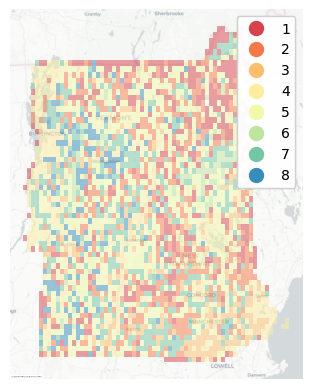

In [20]:
from src.geojson import build_geojson_feature_collection, write_geojson
from src.render import plot_clusters

feature_collection = build_geojson_feature_collection(
    geohash_cluster_dataframe,
    cluster_colors_dataframe,
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

write_geojson(feature_collection, output_file)

# Build and display HTML output

In [21]:
from src.html_output import build_html_output
from IPython.display import display, HTML

html = build_html_output(
    cluster_colors_dataframe,
    cluster_significant_differences_dataframe,
)

display(HTML(html))


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
    perplexity=min(30, distance_matrix.squareform().shape[0] - 1), # HACK FOR SMALLER DATASETS
)
X_tsne = tsne.fit_transform(distance_matrix.squareform())
tsne.kl_divergence_


2.0060346126556396

<Axes: >

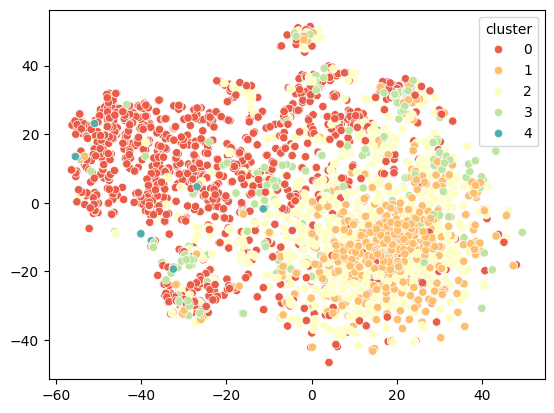

In [ ]:
import seaborn as sns

sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=geohash_cluster_dataframe.df["cluster"],
    palette=cluster_colors_dataframe.to_dict(),
    alpha=1,
)

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
from scipy.cluster.hierarchy import linkage

from src.darwin_core import TaxonRank

linkage_array = linkage(distance_matrix.condensed(), "ward")

ordered_geohashes = geohash_taxa_counts_dataframe.ordered_geohashes()

def min_max_normalize(series: pl.Series) -> pl.Series:
    return (series - series.min()) / (series.max() - series.min())

col_colors = []
for geohash in ordered_geohashes:
    cluster = geohash_cluster_dataframe.cluster_for_geohash(geohash)
    col_colors.append(cluster_colors_dataframe.get_color_for_cluster(cluster))

data = {}
for species in cluster_significant_differences_dataframe.df["taxon"].unique():
    counts = []

    for geohash in ordered_geohashes:
        geohash_counts_species = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash, pl.col("name") == species
        ).get_column("count").sum()
        geohash_counts_all = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash
        ).get_column("count").sum()
        geohash_average = geohash_counts_species / geohash_counts_all
        all_average = (
            cluster_taxa_statistics_dataframe.df.filter(
                # pl.col("kingdom") == kingdom, FIXME
                pl.col("name") == species,
                pl.col("cluster").is_null(),
                pl.col("rank") == TaxonRank.species,
            )
            .get_column("average")
            .item()
        )
        counts.append(geohash_average - all_average)
    counts = pl.Series(
        values=counts,
        name=species,
    )
    # counts = counts / counts.max()
    # counts = counts.pow(1 / 3)
    data[species] = min_max_normalize(counts)


KeyboardInterrupt: 

In [33]:
data

{'Cardinalis cardinalis': shape: (2_970,)
 Series: 'Cardinalis cardinalis' [f64]
 [
 	0.121786
 	0.301942
 	0.060893
 	0.281348
 	0.427453
 	…
 	0.0
 	0.0
 	0.0
 	0.0
 	0.0
 ],
 'Catharus guttatus': shape: (2_970,)
 Series: 'Catharus guttatus' [f64]
 [
 	0.148598
 	0.010526
 	0.018575
 	0.006816
 	0.03177
 	…
 	0.0
 	0.0
 	0.0
 	0.067807
 	0.189901
 ],
 'Leuconotopicus villosus': shape: (2_970,)
 Series: 'Leuconotopicus villosus' [f64]
 [
 	0.090426
 	0.076865
 	0.011303
 	0.061086
 	0.054776
 	…
 	0.132124
 	0.0
 	0.0
 	0.0
 	0.0
 ],
 'Anas platyrhynchos': shape: (2_970,)
 Series: 'Anas platyrhynchos' [f64]
 [
 	0.0
 	0.164657
 	0.045878
 	0.181617
 	0.0
 	…
 	0.0
 	0.0
 	0.0
 	0.0
 	0.034743
 ],
 'Geothlypis trichas': shape: (2_970,)
 Series: 'Geothlypis trichas' [f64]
 [
 	0.106383
 	0.048983
 	0.033245
 	0.059888
 	0.103298
 	…
 	0.07772
 	0.0
 	0.25
 	0.048544
 	0.151057
 ],
 'Zonotrichia albicollis': shape: (2_970,)
 Series: 'Zonotrichia albicollis' [f64]
 [
 	0.031699
 	0.031436

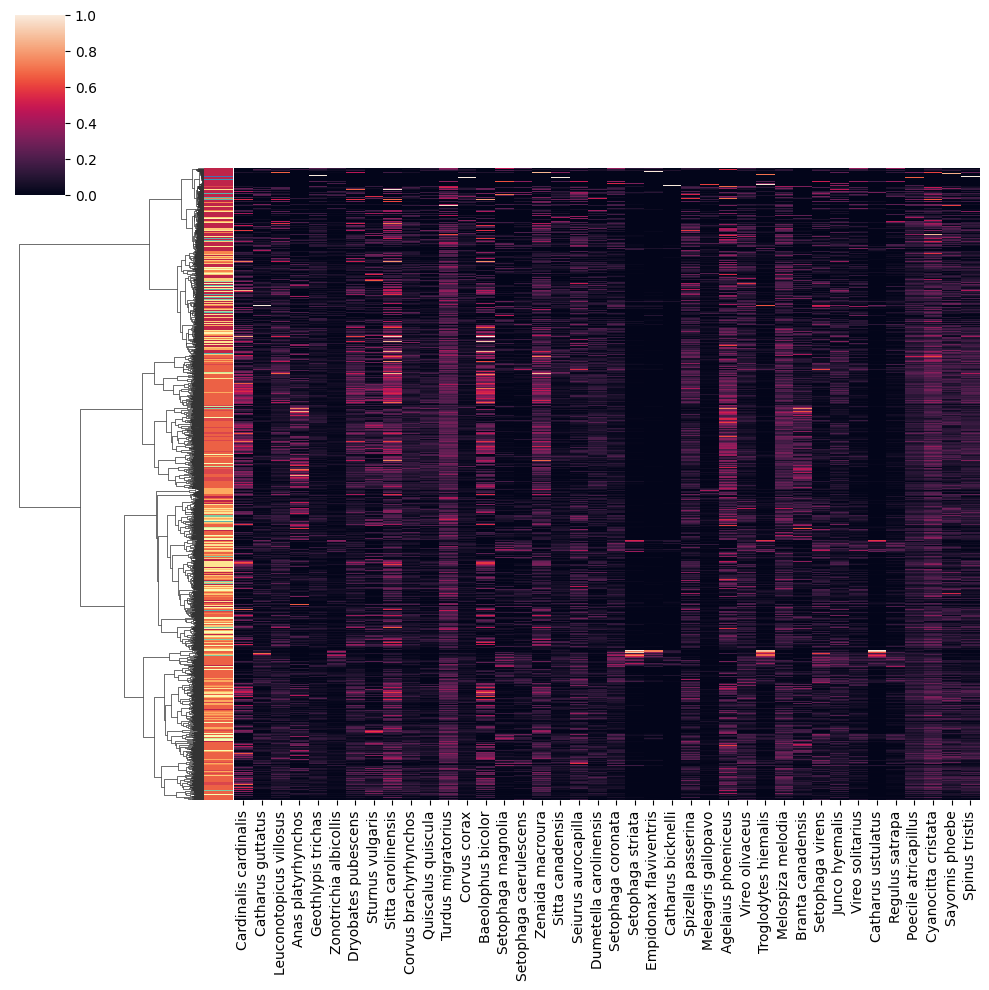

In [34]:
dataframe = pl.DataFrame(data=data)
sns.clustermap(
    data=dataframe,
    col_cluster=False,
    row_cluster=True,
    row_linkage=linkage_array,
    row_colors=col_colors,
    xticklabels=dataframe.columns,
    yticklabels=False,
)